In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix

In [2]:
df = pd.read_csv("addresses.csv", index_col = 0)

print(f"Number of scam addresses          : {len(df[df['flag']] )}")
print(f"Number of non-scam addresses      : {len(df[~df['flag']])}")
print(f"Number of total addresses         : {len(df)}")

Number of scam addresses          : 4834
Number of non-scam addresses      : 13223
Number of total addresses         : 18057


In [3]:
df.sample(5)

,address,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and_last (Mins),Sent_tnx,Received_tnx,NumberofCreated_Contracts,UniqueReceivedFrom_Addresses,UniqueSentTo_Addresses20,MinValueReceived,...,ERC20MaxVal_Rec,ERC20AvgVal_Rec,ERC20MinVal_Sent,ERC20MaxVal_Sent,ERC20AvgVal_Sent,ERC20UniqSentTokenName,ERC20UniqRecTokenName,ERC20MostSentTokenType,ERC20MostRecTokenType,flag
3876,0x7f151165f7cd0d7417e4b5233b90cf721c34aa2f,0.0,0.000000,0,0,0,0,0,0,0.000000e+00,...,1.337000e+19,1.340000e+19,0.0,0.0,0.0,0,Blockwell say NOTSAFU,0,2,True
6988,0xbbd227e805b90b8fe8f4c01a3f4e48bdae0599af,0.0,980.227698,9747273,0,9944,1,1428,0,0.000000e+00,...,5.000000e+08,1.045223e+08,0.0,0.0,0.0,0,Phoneum Token,0,2,False
3633,0x69C24164B73693656747759181FDBe24Ac9607C3,0.0,75049.000000,375245,0,6,0,4,0,1.000000e+18,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0,0,0,0,True
14850,0x7b102e2d9743e51fe420ec04e904b9d4e3e982a1,0.0,733917.325600,95822880,0,130,1,13,0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0,0,0,0,False
4061,0x8ab73681C7804406c71D62872be0CCd1bF9Fc2E8,0.0,0.000000,0,0,0,0,0,0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0,0,0,0,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18057 entries, 0 to 18068
Data columns (total 44 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   address                                           18057 non-null  object 
 1   Avg min between sent tnx                          18057 non-null  float64
 2   Avg min between received tnx                      18057 non-null  float64
 3   Time Diff between first and_last (Mins)           18057 non-null  int64  
 4   Sent_tnx                                          18057 non-null  int64  
 5   Received_tnx                                      18057 non-null  int64  
 6   NumberofCreated_Contracts                         18057 non-null  int64  
 7   UniqueReceivedFrom_Addresses                      18057 non-null  int64  
 8   UniqueSentTo_Addresses20                          18057 non-null  int64  
 9   MinValueReceived 

In [5]:
categories = df.select_dtypes('O').columns.astype('category')
df[categories].sample(5)

,address,ERC20UniqSentTokenName,ERC20UniqRecTokenName
654,0x1447b1cb205158d98fdbd312b37ed9dd1481fb62,0,Arnoya classic
11704,0x36a0356d43ee4168ed24efa1cae3198708667ac0,stETH,Dai Stablecoin
5872,0x67e4bbe50fbc74633dfd9f7683465c02af896541,OMG Network,INS Promo
11876,0x07eaa7cc443d53262766d75d59a28b1284cae24f,0,0
15767,0xe584247a8b83fe551ac5ef4474d37595bf6c40f9,0,0


In [6]:
df['flag'] = df['flag'].astype(int)

In [7]:
# Drop the two categorical features
df.drop(df[categories], axis=1, inplace=True)

In [8]:
numericals = df.select_dtypes(include = ['int', 'float']).columns

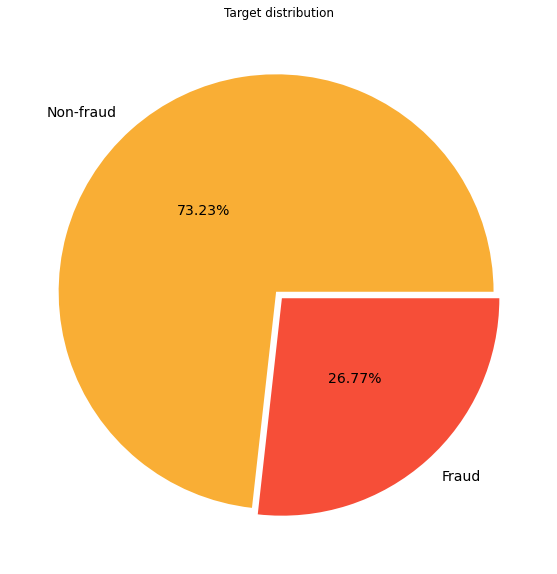

In [9]:
# Inspect target distribution
# print(df['2FLAG'].value_counts())

pie, ax = plt.subplots(figsize=[15,10])
labels = ['Non-fraud', 'Fraud']
colors = ['#f9ae35', '#f64e38']
plt.pie(x = df['flag'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution')
plt.show()

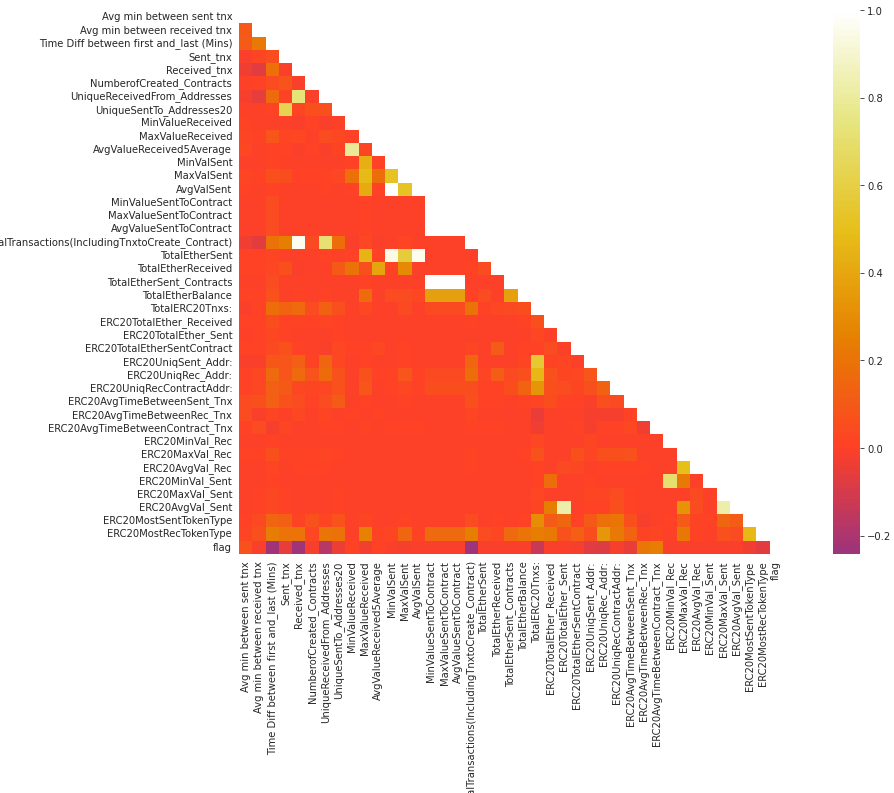

In [10]:
# Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, square=True)

In [11]:
cor = []
for col in corr.columns.to_list():
  cor.append(sum(corr[col]) / len(corr.columns))

print(min(cor))
print(max(cor))

-0.0017713458562046722
0.1449760380196007


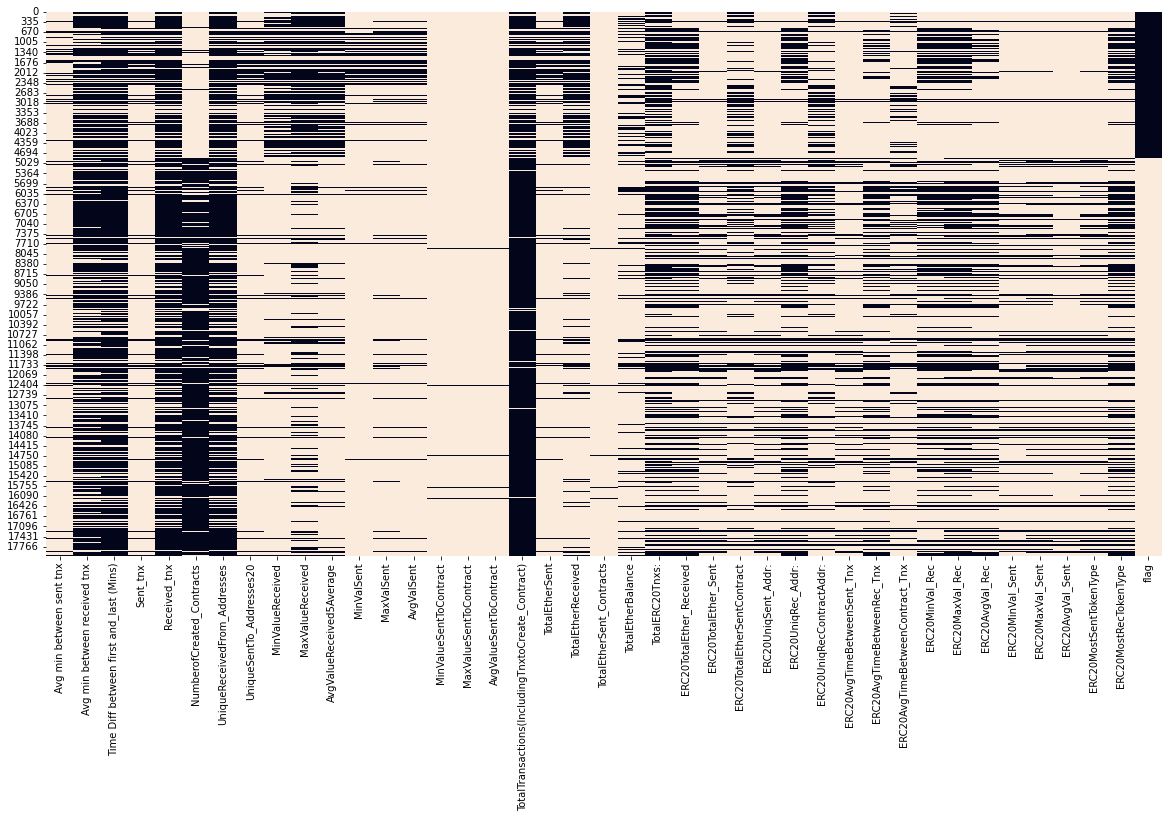

In [12]:
# Visualize missings pattern of the dataframe
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df == 0, cbar=False)
plt.show()

In [13]:
# Filtering the features with 0 variance
no_var = df.var() == 0
print(df.var()[no_var])
print('\n')

# Drop features with 0 variance --- these features will not help in the performance of the model
# df.drop(df.var()[no_var].index, axis = 1, inplace = True)
# print(df.var())
# print(df.shape)

Series([], dtype: float64)




C:\Users\Debasish\AppData\Local\Temp/ipykernel_13652/2579850691.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace = 0.7, hspace=0.8)


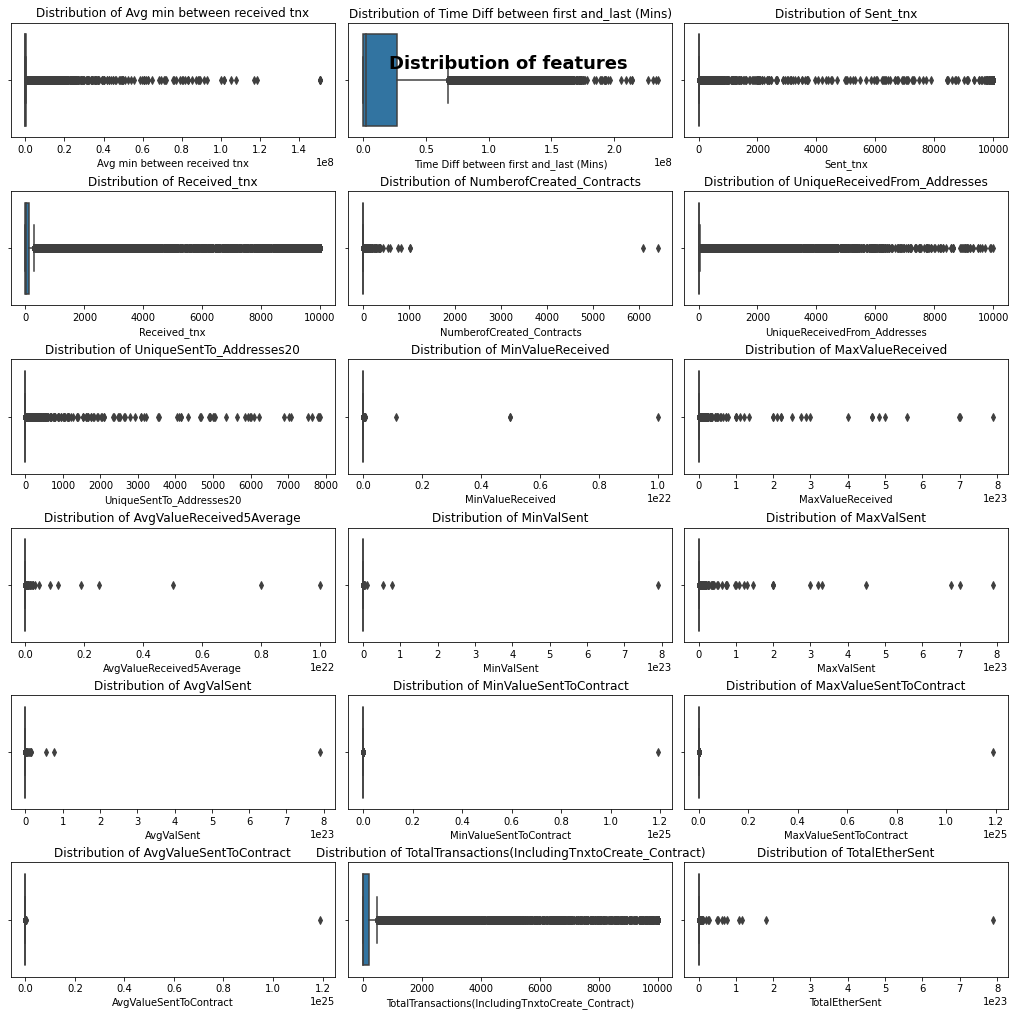

In [14]:
# Investigate the distribution of our features using boxplots
columns = df.columns
b=20

fig, axes = plt.subplots(6, 3, figsize=(14, 14), constrained_layout =True)
plt.subplots_adjust(wspace = 0.7, hspace=0.8)
plt.suptitle("Distribution of features",y=0.95, size=18, weight='bold')

ax = sns.boxplot(ax = axes[0,0], data=df, x=columns[1])
ax.set_title(f'Distribution of {columns[1]}')

ax1 = sns.boxplot(ax = axes[0,1], data=df, x=columns[2])
ax1.set_title(f'Distribution of {columns[2]}')

ax2 = sns.boxplot(ax = axes[0,2], data=df, x=columns[3])
ax2.set_title(f'Distribution of {columns[3]}')

ax3 = sns.boxplot(ax = axes[1,0], data=df, x=columns[4])
ax3.set_title(f'Distribution of {columns[4]}')

ax4 = sns.boxplot(ax = axes[1,1], data=df, x=columns[5])
ax4.set_title(f'Distribution of {columns[5]}')

ax5 = sns.boxplot(ax = axes[1,2], data=df, x=columns[6])
ax5.set_title(f'Distribution of {columns[6]}')

ax6 = sns.boxplot(ax = axes[2,0], data=df, x=columns[7])
ax6.set_title(f'Distribution of {columns[7]}')

ax7 = sns.boxplot(ax = axes[2,1], data=df, x=columns[8])
ax7.set_title(f'Distribution of {columns[8]}')

ax8 = sns.boxplot(ax = axes[2,2], data=df, x=columns[9])
ax8.set_title(f'Distribution of {columns[9]}')

ax9 = sns.boxplot(ax = axes[3,0], data=df, x=columns[10])
ax9.set_title(f'Distribution of {columns[10]}')
 
ax10 = sns.boxplot(ax = axes[3,1], data=df, x=columns[11])
ax10.set_title(f'Distribution of {columns[11]}')

ax11 = sns.boxplot(ax = axes[3,2], data=df, x=columns[12])
ax11.set_title(f'Distribution of {columns[12]}')
 
ax12 = sns.boxplot(ax = axes[4,0], data=df, x=columns[13])
ax12.set_title(f'Distribution of {columns[13]}')
 
ax13 = sns.boxplot(ax = axes[4,1], data=df, x=columns[14])
ax13.set_title(f'Distribution of {columns[14]}')
 
ax14 = sns.boxplot(ax = axes[4,2], data=df, x=columns[15])
ax14.set_title(f'Distribution of {columns[15]}')
 
ax15 = sns.boxplot(ax = axes[5,0], data=df, x=columns[16])
ax15.set_title(f'Distribution of {columns[16]}')
 
ax16 = sns.boxplot(ax = axes[5,1], data=df, x=columns[17])
ax16.set_title(f'Distribution of {columns[17]}')
 
ax17 = sns.boxplot(ax = axes[5,2], data=df, x=columns[18])
ax17.set_title(f'Distribution of {columns[18]}')

plt.show()

In [15]:
# Some features present a small distribution
for i in df.columns[1:]:
    if len(df[i].value_counts()) < 20:
        print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
        print('======================================')

The column flag has the following distribution: 
0    13223
1     4834
Name: flag, dtype: int64


## Data Preprocessing

In [16]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
print(X.shape, y.shape)

(18057, 40) (18057,)


In [17]:
# Split into training (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14445, 40) (14445,)
(3612, 40) (3612,)


In [18]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer

ss = StandardScaler()
rs = RobustScaler()
qt = QuantileTransformer(output_distribution='normal', n_quantiles=891)
yj = PowerTransformer(method = 'yeo-johnson')

In [19]:
ss_data = ss.fit_transform(X_train)
rs_data = rs.fit_transform(X_train)
qt_data = qt.fit_transform(X_train)
yj_data = yj.fit_transform(X_train)

ss_test = ss.fit_transform(X_test)
rs_test = rs.fit_transform(X_test)
qt_test = qt.fit_transform(X_test)
yj_test = yj.fit_transform(X_test)

C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


0.7926356589147286
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      2627
           1       0.93      0.26      0.41       985

    accuracy                           0.79      3612
   macro avg       0.85      0.63      0.64      3612
weighted avg       0.82      0.79      0.75      3612

[[2607   20]
 [ 729  256]]


C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


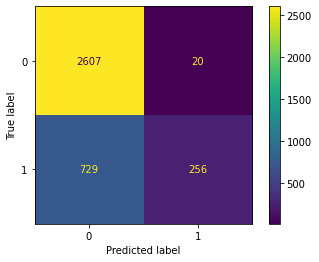

In [20]:
lr = LogisticRegression(random_state = 20, solver = 'saga', max_iter = 200)
lr.fit(ss_data, y_train)

preds = lr.predict(ss_test)

print(lr.score(ss_test, y_test))

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))
plot_confusion_matrix(lr, ss_test, y_test)

0.5719822812846068
              precision    recall  f1-score   support

           0       0.71      0.70      0.70      2627
           1       0.23      0.24      0.24       985

    accuracy                           0.57      3612
   macro avg       0.47      0.47      0.47      3612
weighted avg       0.58      0.57      0.58      3612

[[1826  801]
 [ 745  240]]


C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


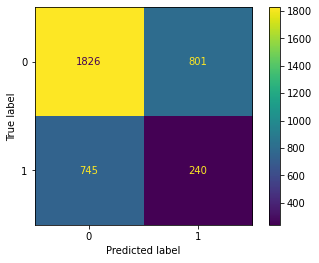

In [21]:
lr = LogisticRegression(random_state = 21, solver = 'saga', max_iter = 100)
lr.fit(rs_data, y_train)

preds = lr.predict(rs_test)

print(lr.score(rs_test, y_test))

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))
plot_confusion_matrix(lr, rs_test, y_test)

0.9598560354374308
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2627
           1       0.92      0.94      0.93       985

    accuracy                           0.96      3612
   macro avg       0.95      0.95      0.95      3612
weighted avg       0.96      0.96      0.96      3612

[[2544   83]
 [  62  923]]


C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


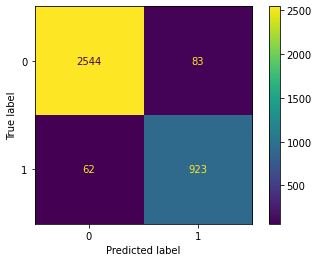

In [22]:
lr = LogisticRegression(random_state = 22, solver = 'saga', max_iter = 100)
lr.fit(qt_data, y_train)

preds = lr.predict(qt_test)

print(lr.score(qt_test, y_test))

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))
plot_confusion_matrix(lr, qt_test, y_test)

0.9593023255813954
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2627
           1       0.91      0.94      0.93       985

    accuracy                           0.96      3612
   macro avg       0.95      0.95      0.95      3612
weighted avg       0.96      0.96      0.96      3612

[[2539   88]
 [  59  926]]


C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


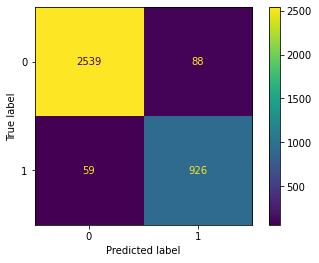

In [23]:
lr = LogisticRegression(random_state = 23, solver = 'saga', max_iter = 100)
lr.fit(yj_data, y_train)

preds = lr.predict(yj_test)

print(lr.score(yj_test, y_test))

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))
plot_confusion_matrix(lr, yj_test, y_test)

In [24]:
# Normalize the training features
norm = PowerTransformer()
norm_train_f = norm.fit_transform(X_train)

C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [25]:
norm_df = pd.DataFrame(norm_train_f, columns=X_train.columns)
norm_df

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and_last (Mins),Sent_tnx,Received_tnx,NumberofCreated_Contracts,UniqueReceivedFrom_Addresses,UniqueSentTo_Addresses20,MinValueReceived,MaxValueReceived,...,ERC20AvgTimeBetweenRec_Tnx,ERC20AvgTimeBetweenContract_Tnx,ERC20MinVal_Rec,ERC20MaxVal_Rec,ERC20AvgVal_Rec,ERC20MinVal_Sent,ERC20MaxVal_Sent,ERC20AvgVal_Sent,ERC20MostSentTokenType,ERC20MostRecTokenType
0,-0.325113,0.547874,0.596486,-0.390234,0.924403,0.583389,-0.655855,-0.391401,-0.522089,-0.764357,...,-0.605283,-0.485659,-0.623954,-0.737670,-0.605887,-0.413445,-0.449303,-0.368402,-0.452667,-0.731363
1,-0.325113,0.064041,-0.030026,-0.390234,0.827045,0.583389,0.640513,-0.391401,-0.522089,-0.764357,...,1.498551,-0.485659,1.831636,1.313559,1.636782,2.518409,2.255137,2.735390,2.181454,0.838033
2,-0.325113,-1.301286,-1.498985,-0.390234,-1.268932,-1.372760,-1.270209,-0.391401,-0.522089,-0.764357,...,-0.605283,-0.485659,-0.623954,-0.737670,-0.605887,-0.413445,-0.449303,-0.368402,-0.452667,-0.731363
3,3.080656,1.460487,0.501821,2.749471,-0.598706,-1.372760,-0.350126,2.584698,1.923707,1.246178,...,1.600423,-0.485659,1.518950,0.720203,1.177693,-0.413445,2.099342,2.673710,2.181454,0.838033
4,-0.325113,0.629924,0.351198,-0.390234,0.476657,0.583389,-0.350126,-0.391401,-0.522089,-0.764357,...,-0.605283,-0.485659,-0.623954,-0.737670,-0.605887,-0.413445,-0.449303,-0.368402,-0.452667,-0.731363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14440,-0.325113,0.665386,0.636963,-0.390234,0.816681,0.583389,-0.655855,-0.391401,-0.522089,-0.764357,...,-0.605283,-0.485659,-0.623954,-0.737670,-0.605887,-0.413445,-0.449303,-0.368402,-0.452667,-0.731363
14441,-0.325113,0.198323,1.262245,-0.390234,1.651044,0.583389,1.735205,-0.391401,-0.522089,-0.764357,...,1.705248,-0.485659,1.844343,1.450987,1.702675,-0.413445,-0.449303,-0.368402,-0.452667,0.838033
14442,-0.325113,1.312918,0.927747,-0.390234,0.233403,0.583389,0.095505,-0.391401,-0.522089,-0.764357,...,-0.605283,-0.485659,-0.623954,-0.737670,-0.605887,-0.413445,-0.449303,-0.368402,-0.452667,-0.731363
14443,-0.325113,0.750999,1.217031,-0.390234,1.196222,0.583389,1.400623,-0.391401,-0.522089,-0.764357,...,1.428950,1.875322,-0.623954,1.457294,1.687940,2.522764,2.262254,2.736734,2.252191,1.275005


C:\Users\Debasish\AppData\Local\Temp/ipykernel_13652/2509670931.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace = 0.7, hspace=0.8)
findfont: Font family 'Sherif' not found.
findfont: Font family 'Sherif' not found.
findfont: Font family 'Sherif' not found.
findfont: Font family 'Sherif' not found.
findfont: Font family 'Sherif' not found.


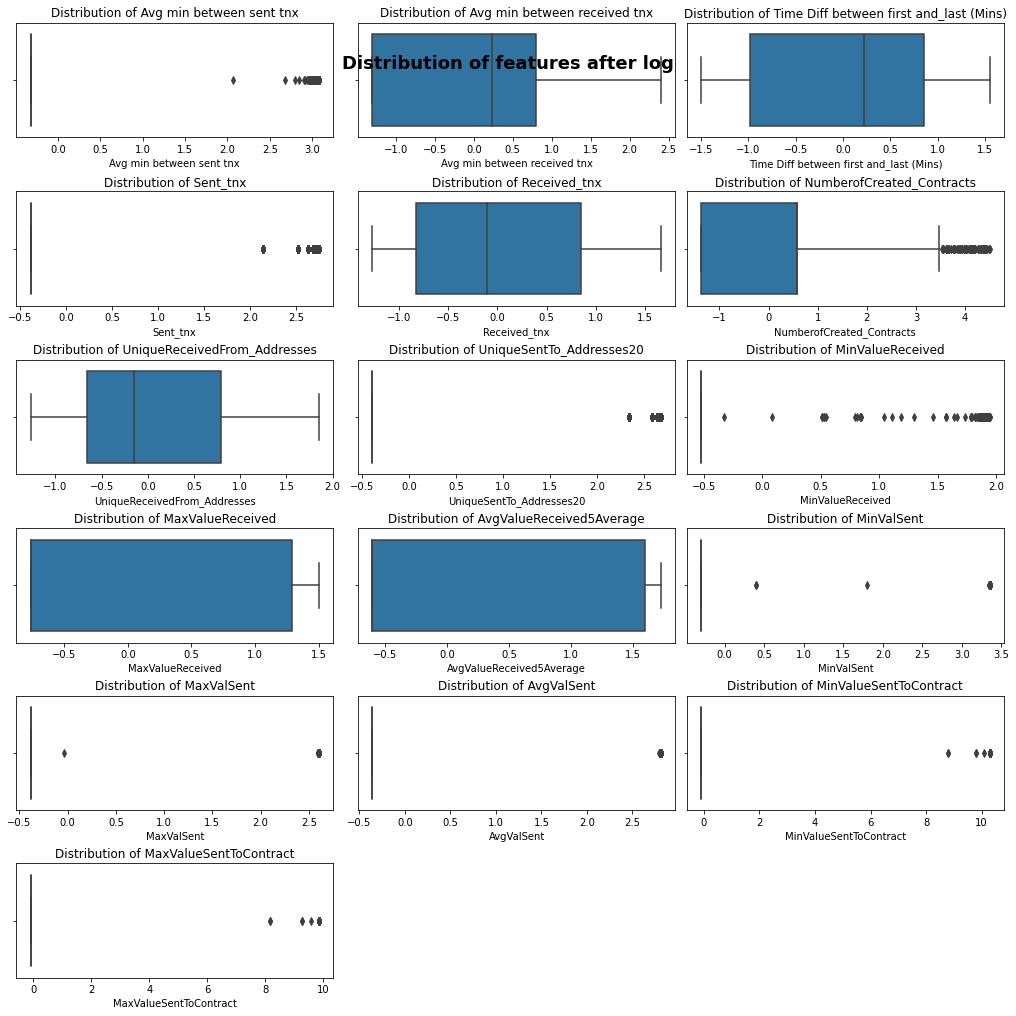

In [26]:
# Distribution of features after log transformation

b=20

fig, axes = plt.subplots(6, 3, figsize=(14, 14), constrained_layout =True)
plt.subplots_adjust(wspace = 0.7, hspace=0.8)
axes[-1, -1].axis('off') # hide axes
axes[-1, -2].axis('off') # hide axes
plt.suptitle("Distribution of features after log",y=0.95, family='Sherif', size=18, weight='bold')
 
ax = sns.boxplot(ax = axes[0,0], data=norm_df, x=norm_df.columns[0])
ax.set_title(f'Distribution of {norm_df.columns[0]}')
 
ax1 = sns.boxplot(ax = axes[0,1], data=norm_df, x=norm_df.columns[1])
ax1.set_title(f'Distribution of {norm_df.columns[1]}')
 
ax2 = sns.boxplot(ax = axes[0,2], data=norm_df, x=norm_df.columns[2])
ax2.set_title(f'Distribution of {norm_df.columns[2]}')
 
ax3 = sns.boxplot(ax = axes[1,0], data=norm_df, x=norm_df.columns[3])
ax3.set_title(f'Distribution of {norm_df.columns[3]}')
 
ax4 = sns.boxplot(ax = axes[1,1], data=norm_df, x=norm_df.columns[4])
ax4.set_title(f'Distribution of {norm_df.columns[4]}')
 
ax5 = sns.boxplot(ax = axes[1,2], data=norm_df, x=norm_df.columns[5])
ax5.set_title(f'Distribution of {norm_df.columns[5]}')
 
ax6 = sns.boxplot(ax = axes[2,0], data=norm_df, x=norm_df.columns[6])
ax6.set_title(f'Distribution of {norm_df.columns[6]}')
 
ax7 = sns.boxplot(ax = axes[2,1], data=norm_df, x=norm_df.columns[7])
ax7.set_title(f'Distribution of {norm_df.columns[7]}')
 
ax8 = sns.boxplot(ax = axes[2,2], data=norm_df, x=norm_df.columns[8])
ax8.set_title(f'Distribution of {norm_df.columns[8]}')
 
ax9 = sns.boxplot(ax = axes[3,0], data=norm_df, x=norm_df.columns[9])
ax9.set_title(f'Distribution of {norm_df.columns[9]}')

ax10 = sns.boxplot(ax = axes[3,1], data=norm_df, x=norm_df.columns[10])
ax10.set_title(f'Distribution of {norm_df.columns[10]}')
 
ax11 = sns.boxplot(ax = axes[3,2], data=norm_df, x=norm_df.columns[11])
ax11.set_title(f'Distribution of {norm_df.columns[11]}')
 
ax12 = sns.boxplot(ax = axes[4,0], data=norm_df, x=norm_df.columns[12])
ax12.set_title(f'Distribution of {norm_df.columns[12]}')
 
ax13 = sns.boxplot(ax = axes[4,1], data=norm_df, x=norm_df.columns[13])
ax13.set_title(f'Distribution of {norm_df.columns[13]}')
 
ax14 = sns.boxplot(ax = axes[4,2], data=norm_df, x=norm_df.columns[14])
ax14.set_title(f'Distribution of {norm_df.columns[14]}')
 
ax15 = sns.boxplot(ax = axes[5,0], data=norm_df, x=norm_df.columns[15])
ax15.set_title(f'Distribution of {norm_df.columns[15]}')

plt.show()

In [27]:
oversample = SMOTE()
print(f'Shape of the training before SMOTE: {norm_train_f.shape, y_train.shape}')

x_tr_resample, y_tr_resample = oversample.fit_resample(norm_train_f, y_train)
print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')

Shape of the training before SMOTE: ((14445, 40), (14445,))
Shape of the training after SMOTE: ((21192, 40), (21192,))


In [28]:
LR = LogisticRegression(random_state=42, max_iter = 200)
LR.fit(x_tr_resample, y_tr_resample)

# Transform test features
norm_test_f = norm.transform(X_test)

preds = LR.predict(norm_test_f)

C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
print(y_test.shape)
y_test.value_counts()

(3612,)


0    2627
1     985
Name: flag, dtype: int64

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2627
           1       0.94      0.96      0.95       985

    accuracy                           0.97      3612
   macro avg       0.96      0.97      0.96      3612
weighted avg       0.97      0.97      0.97      3612

[[2563   64]
 [  39  946]]


C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


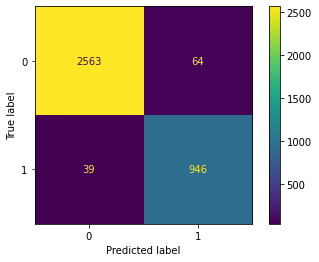

In [30]:
RF = RandomForestClassifier(random_state=42)
RF.fit(x_tr_resample, y_tr_resample)
preds_RF = RF.predict(norm_test_f)

print(classification_report(y_test, preds_RF))
print(confusion_matrix(y_test, preds_RF))
plot_confusion_matrix(RF, norm_test_f, y_test)

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# # encode class values as integers
# encoder = LabelEncoder()
# encoder.fit(Y)
# encoded_Y = encoder.transform(Y)

# baseline model
def build_model():
  # # create model
  # model = Sequential()
  # model.add(Dense(60, input_shape=(60,), activation='relu'))
  # model.add(Dense(1, activation='sigmoid'))
  # # Compile model
  # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  model = Sequential()
  model.add(Dense(512, activation='relu', input_dim=40))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [32]:
model = build_model()
history = model.fit(qt_data, y_train, epochs=40, batch_size=10, validation_split=0.2)

C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/40
1156/1156 [==============================] - 8s 6ms/step - loss: 0.1628 - accuracy: 0.9484 - val_loss: 0.1499 - val_accuracy: 0.9623
Epoch 2/40
1156/1156 [==============================] - 7s 6ms/step - loss: 0.1302 - accuracy: 0.9615 - val_loss: 0.1347 - val_accuracy: 0.9616
Epoch 3/40
1156/1156 [==============================] - 6s 5ms/step - loss: 0.1261 - accuracy: 0.9633 - val_loss: 0.1304 - val_accuracy: 0.9640
Epoch 4/40
1156/1156 [==============================] - 6s 6ms/step - loss: 0.1217 - accuracy: 0.9650 - val_loss: 0.1358 - val_accuracy: 0.9637
Epoch 5/40
1156/1156 [==============================] - 7s 6ms/step - loss: 0.1183 - accuracy: 0.9649 - val_loss: 0.1361 - val_accuracy: 0.9619
Epoch 6/40
1156/1156 [==============================] - 8s 7ms/step - loss: 0.1150 - accuracy: 0.9658 - val_loss: 0.1327 - val_accuracy: 0.9643
Epoch 7/40
1156/1156 [==============================] - 8s 7ms/step - loss: 0.1142 - accuracy: 0.9663 - val_loss: 0.1393 - val_accuracy:

[]

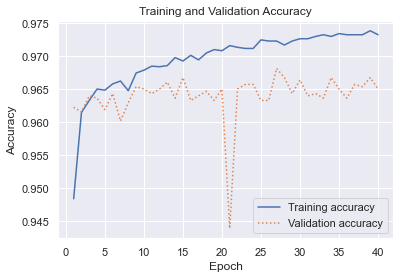

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

113/113 [==============================] - 0s 3ms/step


Text(89.133125, 0.5, 'Actual label')

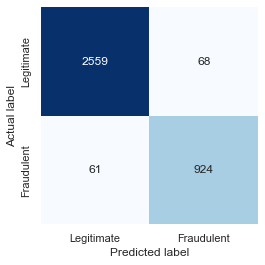

In [34]:
y_predicted = model.predict(qt_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['Legitimate', 'Fraudulent']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

## IMPORTING RIVER

In [39]:
!pip install river

Defaulting to user installation because normal site-packages is not writeable
  Using cached river-0.15.0-cp310-cp310-win_amd64.whl (1.4 MB)


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [40]:
from river import compose
from river import preprocessing
from river import linear_model
from river import metrics
from river import tree
from river import neighbors
from river import ensemble
from river import stream

In [41]:
print(tuple(X.columns.to_list()) == tuple(X.columns))

True


In [42]:
model1 = compose.Pipeline(
    compose.Select(*tuple(X.columns)),
    preprocessing.Normalizer(order=2),
    linear_model.LogisticRegression()
)

model2 = compose.Pipeline(
    compose.Select(*tuple(X.columns)),
    preprocessing.StandardScaler(),
    linear_model.LogisticRegression()
)


model3 = compose.Pipeline(
    compose.Select(*tuple(X.columns)),
    preprocessing.Normalizer(order=2),
    linear_model.ALMAClassifier() 
)

model4 = compose.Pipeline(
    compose.Select(*tuple(X.columns)),
    preprocessing.StandardScaler(),
    linear_model.ALMAClassifier() 
)

model5 = compose.Pipeline(
    compose.Select(*tuple(X.columns)),
    preprocessing.AdaptiveStandardScaler(),
    linear_model.LogisticRegression()
)

model6 = compose.Pipeline(
    compose.Select(*tuple(X.columns)),
    preprocessing.AdaptiveStandardScaler(),
    linear_model.ALMAClassifier() 
)



models = {
    'LogisticRegression_Normalizer': model1, 
    'LogisticRegression_SC': model2, 
    'ALMA Classifier_Normalizer': model3, 
    'ALMA Classifier_SC': model4,
    'LogisticRegression_ASC': model5,
    'ALMA Classifier_ASC': model6
}

In [43]:
#fitting, training and evaluating each algorithm 

metric = metrics.ROCAUC()
metric1 = metrics.Accuracy()
metric2  = metrics.ClassificationReport()
metric3 = metrics.ConfusionMatrix()
# models = {
#     # 'Adaptive Random Forest Classifier':model1, 
#     'Logistic Regression':model2, 
#     # 'AdaBoost Classifier':model3, 
#     'ALMA Classifier':model4}

stats = {}
print('MODEL PERFOMANCE STATS')
print('<--------------------------------------------->')

for i, (name, model) in enumerate(models.items()):
    for xi, yi in stream.iter_pandas(X, y):
        # print(xi)
        # # print(type(xi))
        # print(len(xi))
        # print(X.columns.to_list())
        # print(list(xi.keys()))
        # print(X.columns.to_list() == list(xi.keys()))

        pred = model.predict_proba_one(xi) 
        model.learn_one(xi, yi)
        if pred[True] == 1:
            y_pred = True
        elif pred[False] == 1:
            y_pred = False
        elif pred[True]> pred[False]:
            y_pred = True
        else:
            y_pred= False
        met = metric.update(yi, y_pred)
        met1 = metric1.update(yi, y_pred)
        met2 = metric2.update(yi, y_pred)
        met3 = metric3.update(yi, y_pred)
    stats.update({name:met1.get()})
    print(name)
    print('rocauc Score:>',met)
    metric = metrics.ROCAUC()
    print(name,':Classification Report')
    print('<--------------------------->')
    print(met2)
    print(name,':Confusion Matrix')
    print('<--------------------------->')
    print(met3)
    print('\n< =====================================  END  ===================================== >\n')

MODEL PERFOMANCE STATS
<--------------------------------------------->


C:\Users\Debasish\AppData\Roaming\Python\Python310\site-packages\river\preprocessing\scale.py:475: RuntimeWarning: invalid value encountered in double_scalars
  return {i: xi / norm for i, xi in x.items()}


LogisticRegression_Normalizer
rocauc Score:> ROCAUC: 50.01%
LogisticRegression_Normalizer :Classification Report
<--------------------------->
           Precision   Recall    F1       Support  
                                                   
       0      73.23%   100.00%   84.55%     13223  
       1     100.00%     0.02%    0.04%      4834  
                                                   
   Macro      86.62%    50.01%   42.30%            
   Micro      73.23%    73.23%   73.23%            
Weighted      80.40%    73.23%   61.93%            

                  73.23% accuracy                  
LogisticRegression_Normalizer :Confusion Matrix
<--------------------------->
    0        1  
0   13,223   0  
1    4,833   1  

< =====================================  END  ===================================== >

LogisticRegression_SC
rocauc Score:> ROCAUC: 98.05%
LogisticRegression_SC :Classification Report
<--------------------------->
           Precision   Recall   F1       Sup

In [44]:
model = compose.Pipeline(
    compose.Select(*tuple(X.columns)),
    linear_model.LogisticRegression()
)

met = 0
met1 = 0
met2 = 0
met3 = 0

for xi, yi in stream.iter_pandas(pd.DataFrame(qt_data, columns=X.columns), pd.DataFrame(y_train, columns=['flag'])): 
    # print(xi)
    # # print(type(xi)) 
    # print(len(xi))
    # print(X.columns.to_list())
    # print(list(xi.keys()))
    # print(X.columns.to_list() == list(xi.keys()))

    pred = model.predict_proba_one(xi) 
    model.learn_one(xi, yi)
    if pred[True] == 1:
        y_pred = True
    elif pred[False] == 1:
        y_pred = False
    elif pred[True]> pred[False]:
        y_pred = True
    else:
        y_pred= False
    met = metric.update(yi, y_pred)
    met1 = metric1.update(yi, y_pred)
    met2 = metric2.update(yi, y_pred)
    met3 = metric3.update(yi, y_pred)

print("LR")
print('rocauc Score:>', met)
metric = metrics.ROCAUC()
print(name,':Classification Report')
print('<--------------------------->')
print(met2)
print(':Confusion Matrix')
print('<--------------------------->')
print(met3)
print('\n< =====================================  END  ===================================== >\n')

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'dict'